In [39]:
import jax
import jax.numpy as jnp
from jax import grad, jit, random
import numpy as np
import matplotlib.pyplot as plt

In [40]:
def leapfrog(q, p, grad_U, epsilon, L, M_inv):
    p = p - 0.5 * epsilon * grad_U(q)
    for _ in range(L):
        q = q + epsilon * jnp.dot(M_inv, p)
        if _ < L - 1:
            p = p - epsilon * grad_U(q)
    p = p - 0.5 * epsilon * grad_U(q)
    return q, p

#@jit
def hamiltonian_monte_carlo(key, U, grad_U, epsilon, L, M, num_samples):
    M_inv = jnp.linalg.inv(M)
    samples = []

    q = jnp.zeros(M.shape[0])  # Initial position
    for _ in range(num_samples):
        key, subkey = random.split(key)
        p = random.normal(subkey, shape=q.shape) * jnp.sqrt(jnp.diag(M))

        current_q = q
        current_p = p

        q, p = leapfrog(current_q, current_p, grad_U, epsilon, L, M_inv)

        current_U = U(current_q)
        current_K = 0.5 * jnp.dot(current_p, jnp.dot(M_inv, current_p))
        proposed_U = U(q)
        proposed_K = 0.5 * jnp.dot(p, jnp.dot(M_inv, p))

        acceptance_prob = jnp.exp(current_U - proposed_U + current_K - proposed_K)
        if random.uniform(subkey) < acceptance_prob:
            samples.append(q)
        else:
            samples.append(current_q)
    
    return jnp.array(samples)


In [41]:
mean_true = jnp.array([2.0, 3.0])
cov_true = jnp.array([[1.0, 0.7], [0.7, 1.5]])
cov_inv = jnp.linalg.inv(cov_true)
det_cov = jnp.linalg.det(cov_true)
sqrt_2pi = jnp.sqrt(2 * jnp.pi)

def target_distribution(x):
    # Calculate the exponent in the multivariate normal pdf
    exponent = -0.5 * (x - mean_true) @ cov_inv @ (x - mean_true)
    
    # Calculate the log-pdf using the exponent and normalizing constant terms
    log_pdf = -0.5 * jnp.log(det_cov) - 0.5 * exponent - jnp.log(sqrt_2pi)
    
    return log_pdf

grad_U = jit(grad(target_distribution))
epsilon = 0.1
L = 10
M = jnp.eye(2)  # Identity matrix for simplicity
num_samples = 1000
key = random.PRNGKey(0)

samples = hamiltonian_monte_carlo(key, target_distribution, grad_U, epsilon, L, M, num_samples)

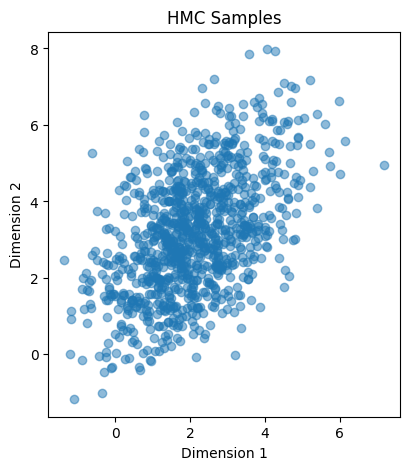

In [42]:
import matplotlib.pyplot as plt

def plot_samples(samples):
    samples = np.array(samples)
    if samples.shape[1] == 2:
        plt.figure(figsize=(10, 5))

        # Plot the samples
        plt.subplot(1, 2, 1)
        plt.plot(samples[:, 0], samples[:, 1], 'o', alpha=0.5)
        plt.title('HMC Samples')
        plt.xlabel('Dimension 1')
        plt.ylabel('Dimension 2')
        
plot_samples(samples)

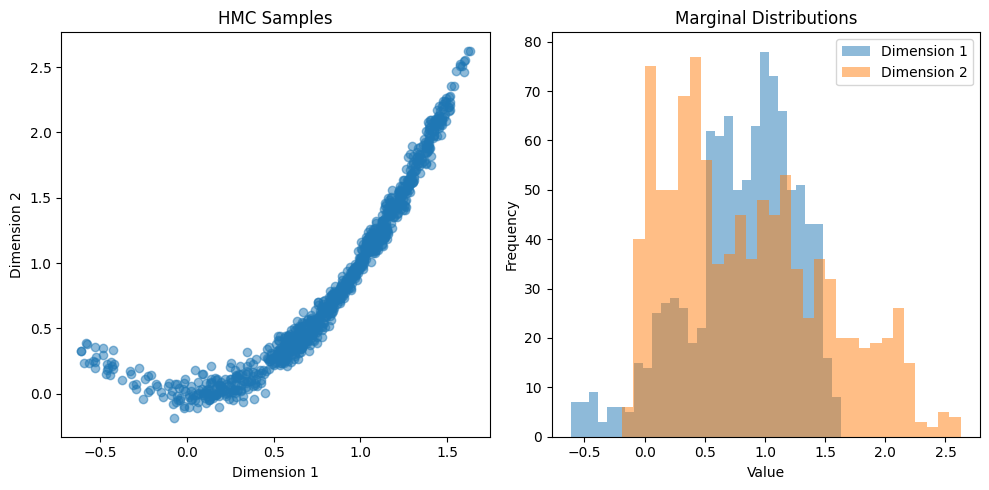

In [43]:
def rosenbrock(x):
    a = 1.0
    b = 100.0
    return (a - x[0])**2 + b * (x[1] - x[0]**2)**2

# The target distribution is proportional to exp(-rosenbrock(x))
def target_distribution(x):
    return rosenbrock(x)

grad_U = jit(grad(target_distribution))
epsilon = 0.001
L = 100
M = jnp.eye(2)  # Identity matrix for simplicity
num_samples = 1000
key = random.PRNGKey(0)

samples = hamiltonian_monte_carlo(key, target_distribution, grad_U, epsilon, L, M, num_samples)

def plot_samples(samples):
    samples = np.array(samples)
    if samples.shape[1] == 2:
        plt.figure(figsize=(10, 5))

        # Plot the samples
        plt.subplot(1, 2, 1)
        plt.plot(samples[:, 0], samples[:, 1], 'o', alpha=0.5)
        plt.title('HMC Samples')
        plt.xlabel('Dimension 1')
        plt.ylabel('Dimension 2')

        # Plot the marginal distributions
        plt.subplot(1, 2, 2)
        plt.hist(samples[:, 0], bins=30, alpha=0.5, label='Dimension 1')
        plt.hist(samples[:, 1], bins=30, alpha=0.5, label='Dimension 2')
        plt.title('Marginal Distributions')
        plt.xlabel('Value')
        plt.ylabel('Frequency')
        plt.legend()

        plt.tight_layout()
        plt.show()
    else:
        # Plot only marginal distributions for higher dimensions
        plt.figure(figsize=(12, 8))
        for i in range(samples.shape[1]):
            plt.subplot(samples.shape[1], 1, i + 1)
            plt.hist(samples[:, i], bins=30, alpha=0.75)
            plt.title(f'Marginal Distribution of Dimension {i+1}')
            plt.xlabel('Value')
            plt.ylabel('Frequency')

        plt.tight_layout()
        plt.show()

# Plot the samples
plot_samples(samples)
